In [1]:
# pip installs
# !pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
# !pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

In [2]:
## imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## Models
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "thilina-llama-3.1-tuned"
HF_USER = "12thilina"

In [4]:
## Runs
RUN_NAME = "2025-09-11_07.10.37"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = "None" # or REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

In [5]:
## Dataset
DATASET_NAME = f"12thilina/sample_amazon_reviews"

In [6]:
## Hyperparameters for QLoRA
QUANT_4_BIT = True

In [7]:
## Others
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [8]:
## Log in to HuggingFace
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

### Load the dataset

In [9]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/9.73M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/771k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Load the Tokenizer and Model

In [10]:
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [11]:
## Load the Tokenizer and the Model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [13]:
## Load the fine-tuned model with PEFT
fine_tuned_model = PeftModel.from_pretrained(base_model, "12thilina/thilina-llama-3.1-tuned-2025-09-11_07.10.37")

print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

adapter_config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

Memory footprint: 5618.8 MB


In [14]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.L

In [15]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [16]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs,
                                        attention_mask = attention_mask,
                                        max_new_tokens = 3,
                                        num_return_sequences = 1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [17]:
# # An improved prediction function takes a weighted average of the top 3 choices
# # This code would be more complex if we couldn't take advantage of the fact
# # That Llama generates 1 token for any 3 digit number

# top_K = 3

# def improved_model_predict(prompt, device="cuda"):
#     set_seed(42)
#     inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
#     attention_mask = torch.ones(inputs.shape, device=device)

#     with torch.no_grad():
#         outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
#         next_token_logits = outputs.logits[:, -1, :].to('cpu')

#     next_token_probs = F.softmax(next_token_logits, dim=-1)
#     top_prob, top_token_id = next_token_probs.topk(top_K)
#     prices, weights = [], []
#     for i in range(top_K):
#       predicted_token = tokenizer.decode(top_token_id[0][i])
#       probability = top_prob[0][i]
#       try:
#         result = float(predicted_token)
#       except ValueError as e:
#         result = 0.0
#       if result > 0:
#         prices.append(result)
#         weights.append(probability)
#     if not prices:
#       return 0.0, 0.0
#     total = sum(weights)
#     weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
#     return sum(weighted_prices).item()

In [18]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $25.00 Truth: $65.99 Error: $40.99 SLE: 0.90 Item: Setpower Insulated P...
2: Guess: $7.00 Truth: $9.68 Error: $2.68 SLE: 0.08 Item: TUAIC Refrigerator D...
3: Guess: $110.00 Truth: $155.98 Error: $45.98 SLE: 0.12 Item: Kegco Secondary Regu...
4: Guess: $7.00 Truth: $5.59 Error: $1.41 SLE: 0.04 Item: Refrigerator Door Sp...
5: Guess: $25.00 Truth: $98.40 Error: $73.40 SLE: 1.80 Item: Ice-O-Matic Float Va...
6: Guess: $25.00 Truth: $54.99 Error: $29.99 SLE: 0.59 Item: Wireless Temperature...
7: Guess: $7.00 Truth: $5.71 Error: $1.29 SLE: 0.03 Item: 3Inch Thermometer Hy...
8: Guess: $7.00 Truth: $9.53 Error: $2.53 SLE: 0.08 Item: GE GE Timer Knob Ass...
9: Guess: $7.00 Truth: $11.24 Error: $4.24 SLE: 0.18 Item: newlifeapp Dryer Lin...
10: Guess: $25.00 Truth: $12.88 Error: $12.12 SLE: 0.39 Item: Away NV350 NV351 NV3...
11: Guess: $110.00 Truth: $99.99 Error: $10.01 SLE: 0.01 Item: Refrigerator Ice Mak...
12: Guess: $19.00 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: 2 PACKS Water

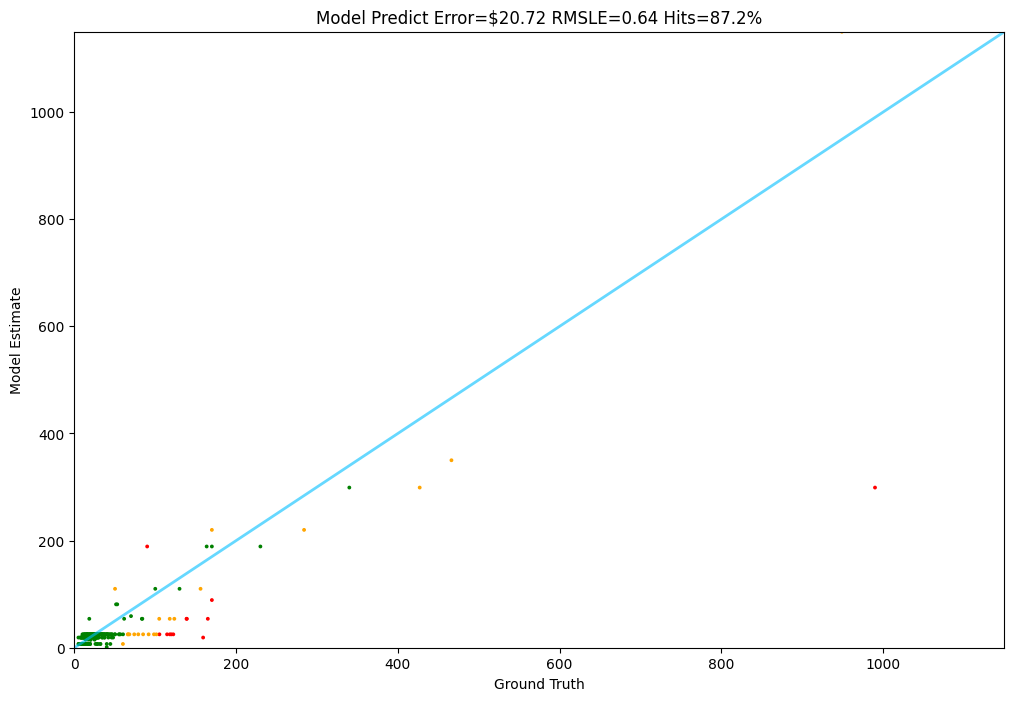

In [19]:
Tester.test(model_predict, test)